# Spark Gaussian Mixture Models

In [1]:
%load_ext autoreload
%matplotlib inline

In [196]:
import os, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as pt
import json
import requests
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('../..')))

from database.CERNMongoClient import CERNMongoClient
from database.CERNSparkClient import CERNSparkClient
from preprocessing import feature_extraction, preprocessing
from pipeline import pipeline
from anomaly_detection import factory
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from sklearn import mixture

# auto-load changes in imported modules
%autoreload 2

# Load features from file

In [197]:
with open('features.json', 'r') as f:
    data = json.load(f)
features = pd.DataFrame(data)
features.index.name = 'timestamp'
features.index = pd.to_datetime(features.index,unit='ms')

In [198]:
display(features.head())

LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
timestamp                                               
2015-06-22 16:14:40                               0.0   
2015-06-22 16:14:50                               0.0   
2015-06-22 16:15:00                               0.0   
2015-06-22 16:15:10                               0.0   
2015-06-22 16:15:20                               0.0   

                     LHC.BCTFR.A6R4.B1:BEAM_INTENSITY:SW_MEAN_DIFF_600_s  \
timestamp                                                                  
2015-06-22 16:14:40                                                  0.0   
2015-06-22 16:14:50                                                  0.0   
2015-06-22 16:15:00                                                  0.0   
2015-06-22 16:15:10                                                  0.0   
2015-06-22 16:15:20                                                  0.0   

                     LHC.BQM.B1:BUNCH_LENGTH_MEAN  \
timestamp                                           
2015-06-22 16:14:40                           0.0   
2015-06-22 16:14:50                           0.0   
2015-06-22 16:15:00                           0.0   
2015-06-22 16:15:10                           0.0   
2015-06-22 16:15:20                           0.0   

                     LHC.BQM.B1:BUNCH_LENGTH_MEAN:SW_MEAN_DIFF_600_s  \
timestamp                                                              
2015-06-22 16:14:40                                              0.0   
2015-06-22 16:14:50                                              0.0   
2015-06-22 16:15:00                                              0.0   
2015-06-22 16:15:10                                              0.0   
2015-06-22 16:15:20                                              0.0   

                     MKI.A5L2.B1:PRESSURE  \
timestamp                                   
2015-06-22 16:14:40          1.000000e-10   
2015-06-22 16:14:50          1.000000e-10   
2015-06-22 16:15:00          1.000000e-10   
2015-06-22 16:15:10          1.000000e-10   
2015-06-22 16:15:20          1.000000e-10   

                     MKI.A5L2.B1:PRESSURE:SW_MEAN_DIFF_600_s  \
timestamp                                                      
2015-06-22 16:14:40                             1.628512e-24   
2015-06-22 16:14:50                             1.628512e-24   
2015-06-22 16:15:00                             1.628512e-24   
2015-06-22 16:15:10                             1.628512e-24   
2015-06-22 16:15:20                             1.628512e-24   

                     MKI.A5L2.B1:TEMP_MAGNET_DOWN  \
timestamp                                           
2015-06-22 16:14:40                          22.3   
2015-06-22 16:14:50                          22.3   
2015-06-22 16:15:00                          22.3   
2015-06-22 16:15:10                          22.3   
2015-06-22 16:15:20                          22.3   

                     MKI.A5L2.B1:TEMP_MAGNET_DOWN:SW_MEAN_DIFF_600_s  \
timestamp                                                              
2015-06-22 16:14:40                                              0.0   
2015-06-22 16:14:50                                              0.0   
2015-06-22 16:15:00                                              0.0   
2015-06-22 16:15:10                                              0.0   
2015-06-22 16:15:20                                              0.0   

                     MKI.A5L2.B1:TEMP_MAGNET_UP  \
timestamp                                         
2015-06-22 16:14:40                        21.0   
2015-06-22 16:14:50                        21.0   
2015-06-22 16:15:00                        21.0   
2015-06-22 16:15:10                        21.0   
2015-06-22 16:15:20                        21.0   

                     MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_600_s  \
timestamp                                                            
2015-06-22 16:14:40                                            0.0   
2

## Now use these features for training

### Do pipeline without labels

In [ ]:
# copied from pipeline_gmm.py

# SET ANOMALY DETECTOR AND PARAMETERS
anomaly_detector = "gmm"
detector_parameters = {
        "n_components": 6,
        "covariance_type": "full",
        "tol": 1e-3,
        "reg_covar": 1e-6,
        "max_iter": 100,
        "n_init": 3,
        "init_params": 'kmeans',
        "weights_init": None,
        "means_init": None,
        "precisions_init": None,
        "random_state": None,
        "warm_start": False,
        "verbose": 1,
        "verbose_interval": 10
}

detector = factory.AnomalyDetectorFactory.create(anomaly_detector, **detector_parameters)

In [ ]:
features_scored = pipeline.pipeline_train_and_predict(detector,features)

In [ ]:
display(features_scored.tail())

### Train using MLLib

In [20]:
from pyspark.ml.clustering import GaussianMixture

In [199]:
url='http://student.kuleuven.be/~r0576762/data/cern/data.txt'
df = spark.createDataFrame(pd.read_csv(url))

### GMM example from Spark documentation
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.GaussianMixture

In [221]:
from pyspark.ml.linalg import Vectors
data = [(Vectors.dense([0.1, 0.05 ]),),
        (Vectors.dense([0.01, 0.1]),),
        (Vectors.dense([0.83, 0.25]),),
        (Vectors.dense([0.91, 0.12]),),
        (Vectors.dense([0.95, 0.18]),),
        (Vectors.dense([0.05, 0.98]),),
        (Vectors.dense([0.03, 0.91]),),
        (Vectors.dense([0.98, 0.84]),),
        (Vectors.dense([0.90, 0.89]),),
        (Vectors.dense([0.50, 0.50]),)]

In [222]:
df = spark.createDataFrame(data, ["features"])

In [223]:
gm = GaussianMixture(k=3, tol=0.0001, maxIter=10, seed=10)
model = gm.fit(df)

In [224]:
prediction = model.transform(df)

In [225]:
pd.set_option('max_colwidth',100)
display(prediction.toPandas())

features  prediction  \
0   [0.1, 0.05]           2   
1   [0.01, 0.1]           2   
2  [0.83, 0.25]           1   
3  [0.91, 0.12]           1   
4  [0.95, 0.18]           1   
5  [0.05, 0.98]           1   
6  [0.03, 0.91]           1   
7  [0.98, 0.84]           0   
8   [0.9, 0.89]           0   
9    [0.5, 0.5]           1   

                                                            probability  
0  [1.0319933576598601e-16, 1.0319933576598601e-16, 0.9999999999999998]  
1  [1.0554437664297329e-16, 1.0554437664297329e-16, 0.9999999999999998]  
2    [0.0031126479883951757, 0.9949648246358906, 0.0019225273757141612]  
3        [0.00819772540091376, 0.9192474191829773, 0.07255485541610913]  
4       [0.021413087872862415, 0.8013928080597049, 0.17719410406743263]  
5  [1.8223508288541742e-16, 0.9999999999999997, 1.8223508288541742e-16]  
6  [1.2881081892140362e-16, 0.9999999999999998, 1.2881081892140362e-16]  
7                   [1.0, 9.187606576911596e-17, 9.187606576911596e-17]  
8                   [1.0, 9.176373760226676e-17, 9.176373760226676e-17]  
9                  [5.044079750433061e-17, 1.0, 5.0440778997946256e-17]

### Train simple example with scikitlearn

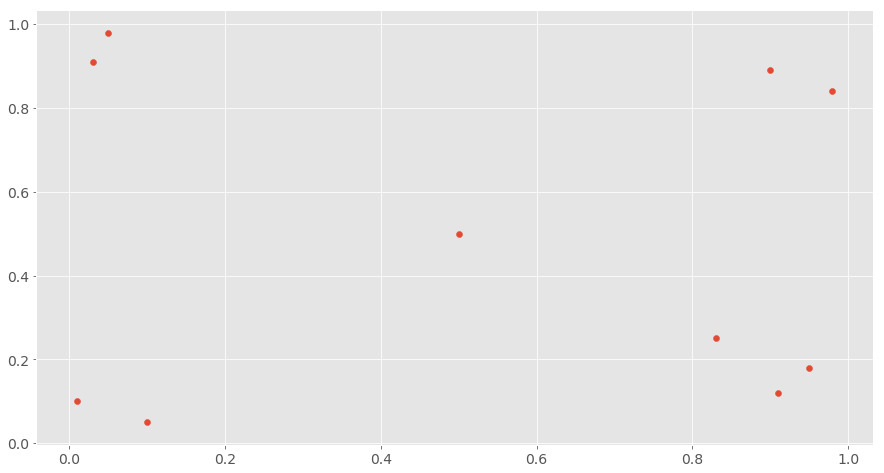

In [226]:
data=[[0.1, 0.05],[0.01, 0.1], [0.83, 0.25], [0.91, 0.12], [0.95, 0.18], [0.05, 0.98], [0.03, 0.91], [0.98,0.84],[0.90,0.89],[0.5,0.5]]
data = pd.DataFrame(data,columns=['A','B'])
preprocessing.scale(data)
pt.scatter(data['A'],data['B'])
gmm = mixture.GaussianMixture(n_components=4)
gmm.fit(data)
scores = gmm.score_samples(data)
scores = -scores
scores=preprocessing.scale_array(scores)
scores=data.assign(score=scores)

In [227]:
display(scores)

A     B         score
0  0.10  0.05  6.468200e-02
1  0.01  0.10  6.468200e-02
2  0.83  0.25  7.460900e-01
3  0.91  0.12  1.000000e+00
4  0.95  0.18  9.212227e-01
5  0.05  0.98  1.255098e-10
6  0.03  0.91  0.000000e+00
7  0.98  0.84  4.837004e-02
8  0.90  0.89  4.837004e-02
9  0.50  0.50  9.916396e-01

### Train using Scikit-learn

In [55]:
# Parameters
n_components=6
covariance_type= "full"
tol= 1e-3
reg_covar= 1e-6
max_iter= 100
n_init= 3
init_params= 'kmeans'
weights_init= None
means_init= None
precisions_init= None
random_state=None
warm_start=False
verbose=1
verbose_interval= 10

In [56]:
# Initialize
gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=covariance_type, tol=tol,
            reg_covar=reg_covar, max_iter=max_iter, n_init=n_init, init_params=init_params,
            weights_init=weights_init, means_init=means_init, precisions_init=precisions_init,
            random_state=random_state, warm_start=warm_start, verbose=verbose, verbose_interval=verbose_interval)

In [57]:
# Scale data
features = preprocessing.scale(features)

/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc62-opt/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [58]:
gmm.fit(features)

Initialization 0
  Iteration 0
Initialization converged: True
Initialization 1
  Iteration 0
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [59]:
scores = gmm.score_samples(features)
scores = - scores # larger scores more anomalous
scores = preprocessing.scale_array(scores)

In [60]:
display(scores)

array([2.36235064e-01, 1.52057236e-01, 1.89661319e-01, 1.44267737e-01,
       1.83054454e-01, 1.46077652e-01, 1.27831361e-01, 1.45835572e-01,
       1.39954865e-01, 1.30275167e-01, 1.31047104e-01, 1.92809299e-01,
       1.35144546e-01, 1.36953370e-01, 1.32053124e-01, 1.20291907e-01,
       1.23753838e-01, 1.28311887e-01, 1.26995311e-01, 1.45629993e-01,
       1.20430553e-01, 1.21515776e-01, 1.23337170e-01, 1.69202365e-01,
       1.24544361e-01, 1.23416329e-01, 1.25987456e-01, 1.23422056e-01,
       1.26947219e-01, 1.31402707e-01, 1.20412448e-01, 1.37694986e-01,
       1.28296918e-01, 1.29393630e-01, 1.24049910e-01, 1.40049370e-01,
       1.21951450e-01, 1.37215200e-01, 1.23262448e-01, 1.80954439e-01,
       1.25516365e-01, 1.29776338e-01, 1.42901390e-01, 1.52157865e-01,
       1.38504465e-01, 1.53983167e-01, 1.67986440e-01, 1.30913794e-01,
       1.33393072e-01, 1.29503601e-01, 1.33468685e-01, 1.30167228e-01,
       1.34713921e-01, 1.32082463e-01, 1.71060512e-01, 1.39495210e-01,
      

(array([  7., 246., 470.,  19.,   4.,   0.,   1., 155.,  14.,   8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

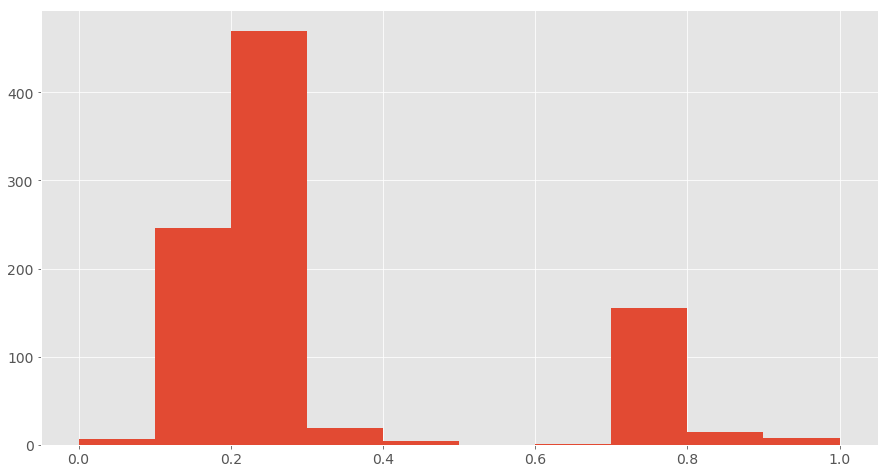

In [67]:
pt.hist(scores)